# Robustness of SimpleNet vs MirrorNet

Based on this it seems like very simple networks are quite robust to gradient based adversaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

from simplenet import *
from mirrornet import *

from utils import *

gpu_dtype = torch.cuda.FloatTensor

loader_train, loader_val, loader_test = get_cifar_loaders()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
from importlib import reload

import simplenet
reload(simplenet)
from simplenet import *

import utils
reload(utils)
from utils import *

simplenet = SimpleNet().cuda()
# mirrornet = MirrorNet().cuda()
print(get_param_count(simplenet))
# print(get_param_count(mirrornet))

In [4]:
simpletrainer = Trainer(simplenet, loader_train, loader_val)
simpletrainer.train_schedule([10, 5, 2])

Training for 10 epochs with learning rate 0.100000
Starting epoch 1 / 10
loss = 1.4767
Got 2306 / 5000 correct (46.12)
Starting epoch 2 / 10
loss = 1.2907
Got 2576 / 5000 correct (51.52)
Starting epoch 3 / 10
loss = 1.1951
Got 2827 / 5000 correct (56.54)
Starting epoch 4 / 10
loss = 1.2108
Got 2987 / 5000 correct (59.74)
Starting epoch 5 / 10
loss = 1.2834
Got 3060 / 5000 correct (61.20)
Starting epoch 6 / 10
loss = 1.0657
Got 3180 / 5000 correct (63.60)
Starting epoch 7 / 10
loss = 1.1030
Got 3043 / 5000 correct (60.86)
Starting epoch 8 / 10
loss = 1.1521
Got 3274 / 5000 correct (65.48)
Starting epoch 9 / 10
loss = 1.0785
Got 3302 / 5000 correct (66.04)
Starting epoch 10 / 10
loss = 1.2090
Got 3362 / 5000 correct (67.24)
Training for 5 epochs with learning rate 0.100000
Starting epoch 1 / 5
loss = 0.9606
Got 3325 / 5000 correct (66.50)
Starting epoch 2 / 5
loss = 1.0098
Got 3360 / 5000 correct (67.20)
Starting epoch 3 / 5


KeyboardInterrupt: 

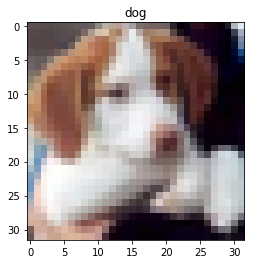

dog


In [5]:
images, labels = iter(loader_test).next()
i = 16
image, label = images[i, np.newaxis], labels[i]
img_var = Variable(image.cuda(), requires_grad=True)
imshow(image, label)
print(CIFAR_CLASSES[simplenet(img_var).max(0)[1].data[0]])

In [12]:
simplenet

<module 'simplenet' from '/home/keller/Adversarial/simplenet.py'>

In [11]:
def adversarial_attack(model, img_var, alpha=.005):
    for param in model.parameters():
        param.requires_grad = False
    
    target = 3
    
    adv_img_var = Variable(img_var.data.clone(), requires_grad=True)
    
    difference = torch.zeros_like(adv_img_var.data)
    
    num_epochs = 1000
    for epoch in range(num_epochs):
        scores = model(adv_img_var)

        objective = scores.squeeze()[target]
        objective.backward()
        g = adv_img_var.grad.data.clone()
        adv_img_var.grad.zero_()
        g = g / g.norm()

        diff_epoch = alpha * g
        adv_img_var.data += diff_epoch.cuda()
        difference += diff_epoch
        adv_img_var.data = torch.clamp(adv_img_var.data, min=-1, max=1)
        difference = torch.clamp(difference, min=-1, max=1)
        
#         print(scores.data[target])\
        if epoch % 100 == 0:
            print(CIFAR_CLASSES[scores.max(0)[1].data[0]])
#         print(scores.data.cpu().numpy())
    
    for param in model.parameters():
        param.requires_grad = True
    
    return adv_img_var, difference

adv_img_var, difference = adversarial_attack(simplenet, img_var, alpha=0.01)

imshow(adv_img_var.data.cpu().numpy(), label)
imshow(difference.cpu().numpy(), 0)
# imshow(img_var.data.cpu().numpy(), label)

AttributeError: module 'simplenet' has no attribute 'parameters'